<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TestingNVPExtensionGaussianLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip

     - 11.1MB 19.9MB/s


In [0]:
import corner

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

W0505 16:12:10.461861 140256009533312 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [145]:
generator_path = './gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/gauss3b/gauss3b-final/encoder'
nvp_func_path      = './gdrive/My Drive/MPM/modules/gauss3b/nvp-final4'
minima_path      = './gdrive/My Drive/MPM/modules/gauss3b/minima/'
!ls ./gdrive/My\ Drive/MPM/modules/gauss3b/nvp-final/

ls: cannot access './gdrive/My Drive/MPM/modules/gauss3b/nvp-final/': No such file or directory


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [164]:
#finding EL2O 'by hand'
tf.reset_default_graph()

batch_size    = 512
batch_size_2  = 1
hidden_size   = 10
sample_size_z = 64
sigma_n       = 0.1
n_channels    = 1
num_comp      = 10

nvp_size      = [[512, 512], [512, 512], [512, 512],[512, 512], [512, 512],[512, 512]]
nvp_prior     = tf.placeholder_with_default(True,shape=[])
true_hess     = tf.placeholder_with_default(True,shape=[])



sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

generator = hub.Module(generator_path, trainable=False)
encoder   = hub.Module(encoder_path, trainable=False)
nvp_funcs = hub.Module(nvp_func_path, trainable=False)

# Define latent space prior
prior             = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
log_det_prior     = tf.linalg.logdet(prior.covariance())

# data
# A) training set (used to train maf/should not be corrupted)
x_tr              = tf.placeholder(shape=[batch_size,784,n_channels], dtype=tf.float32)

prior_sample      = tf.placeholder(shape=[sample_size_z,hidden_size], dtype=tf.float32)

# this is the noise of the corrupted data
sigma_corr        = tf.placeholder_with_default(np.ones([batch_size_2,784,n_channels], dtype='float32')*sigma_n,shape=[batch_size_2,784,n_channels])


# vae does mean field approximation
encoded_data      = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)
sigma             = tf.nn.softplus(sigma) + 0.0001
approx_posterior  = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

vae_liklogits     = tf.reshape(generator(mu),[batch_size,784,1])

# uncoruppted data likelihood
likelihood_vae    = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood_vae.mean()

# test saple from prior
prior_samples     = prior.sample(sample_size_z)
sample_liklogits  = tf.reshape(generator(prior_sample),[-1,784,n_channels])
sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()







### ---- training the nvp ----- ###

# def get_nvp():
  
#   p1 = np.arange(0,hidden_size//2)
#   p2 = np.arange(hidden_size//2,hidden_size)
#   perm=np.concatenate((p2,p1))
  
#   base_dis = tfd.MultivariateNormalDiag(loc=np.zeros(hidden_size, dtype='float32'),scale_identity_multiplier=1.0,name='base_dis')
  
#   chain = []
  
#   for i,s in enumerate(nvp_size):
#     chain.append(tfb.RealNVP(num_masked=5,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
#     chain.append(tfb.Permute(permutation=perm,name='perm%d'%i))

#   nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
#   return nvp

# def nvp_module_spec():
#     z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     sample_size  = tf.placeholder(tf.int32, shape=[])
#     u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
#     nvp_         = get_nvp()
#     log_prob     = nvp_.log_prob(z_sample)
#     nvp_sample   = nvp_.sample(sample_size)
#     nvp_fwd_pass = nvp_.bijector.forward(u_sample)
#     hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

# nvp_spec  = hub.create_module_spec(nvp_module_spec)
# nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

# nvp       = get_nvp()
# loss      = -tf.reduce_mean(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# opt_op    = optimizer.minimize(loss)

### ---- training the nvp ----- ###





# B) corrupted data from test set (networks should not have seen this before)
x_re                 = tf.placeholder(shape=[batch_size_2,784,n_channels], dtype=tf.float32)

#### for naive recon and strating MAP finding at truth

### for corrupted data, we need different batch size:
encoded_data_c    = encoder(tf.reshape(x_re,[-1,28,28,n_channels]))
mu_c, sigma_c     = tf.split(encoded_data_c, 2, axis=-1)

# # coruppted data likelihood
corr_liklogits    = tf.reshape(generator(mu_c),[batch_size_2,784,n_channels])
likelihood_corr   = tfd.Independent(tfd.MultivariateNormalDiag(loc=corr_liklogits,scale_identity_multiplier=sigma_corr))
corr_recon        = likelihood_vae.mean()

### estimate the MAP for ###
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size_2,hidden_size]),shape=[batch_size_2,hidden_size])
MAP                  = tf.Variable(MAP_ini)

MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))

fwd_MAP              = nvp_funcs({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':MAP},as_dict=True)['fwd_pass']

# option to use uncorrected latent space
genMAP               = tf.reshape(tf.cond(nvp_prior, lambda: generator(fwd_MAP), lambda: generator(MAP)),[batch_size_2,784,n_channels])

likeli_MAP           = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).log_prob(x_re)

prior_MAP            = prior.log_prob(MAP)

posterior_MAP        = prior_MAP+likeli_MAP

loss_MAP             = -tf.reduce_mean(posterior_MAP)

opt_op2              = optimizer.minimize(loss_MAP, var_list=[MAP])

MAP_mean             = tfd.Independent(tfd.Normal(loc=genMAP,scale=sigma_corr)).mean()


##### do Laplace approximation
ini_val  = np.ones((batch_size_2,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size_2,hidden_size),dtype=np.float32), dtype=np.float32)
  sigma_new_t = ini_val
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)


update2          = tf.stop_gradient(mu_new.assign(MAP))

# this is exact hessian computation 
hess             = tf.hessians(-posterior_MAP,MAP)
hess             = tf.gather(hess, 0)
hess2            = tf.reduce_sum(hess, axis = 2 )

#constructing Hessian from known analytic form of posterior (this is for Gaussian likelihood+prior with unit variance)


grad_g           = tf.gather(tf.gradients(genMAP/(sigma_corr),MAP),0)

grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

#symmetrization
grad_g2          = 0.5*(grad_g2+tf.linalg.transpose(grad_g2))

one              = tf.linalg.eye(hidden_size, batch_shape=[batch_size_2],dtype=tf.float32)

hess_approx      = one+grad_g2

eig1             = tf.linalg.eigvalsh(hess_approx)

sigma_hess       = tf.cond(true_hess, lambda: tf.linalg.inv(hess2), lambda: tf.linalg.inv(hess_approx))

sigma_hess       = 0.5*(sigma_hess+tf.linalg.transpose(sigma_hess))

eig2             = tf.linalg.eigvalsh(sigma_hess)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_hess))

lap_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])
lap_liklogits    = tf.reshape(generator(lap_z_samples),[-1,784,n_channels])
lap_likelihood   = tfd.Independent(tfd.Normal(loc=lap_liklogits,scale=sigma_corr))
lap_mean         = lap_likelihood.mean()
lapl_variance_MAP= tf.linalg.diag_part(approx_posterior_laplace.covariance())


# # # construct a GMM approximation from different minima

# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((batch_size_2,num_comp,hidden_size)), dtype=np.float32)
#   ini_val2    = np.ones((batch_size_2,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
#   sigma_gmm   = tf.constant(ini_val2)
#   sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

# mu_est        = tf.placeholder_with_default(tf.zeros([batch_size_2,num_comp,hidden_size]),shape=[batch_size_2,num_comp,hidden_size])
# sigma_est     = tf.placeholder_with_default(tf.ones([batch_size_2,num_comp,hidden_size, hidden_size]),shape=[batch_size_2,num_comp,hidden_size, hidden_size])
# w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_a      = w_gmm.assign(w_est)
# update_b      = mu_gmm.assign(mu_est)
# update_c      = sigma_gmmt.assign(sigma_est)

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# gmm_sample_z  = gmm.sample(sample_size_z)
# #gmm_sample_x  = tfd.Independent(tfd.Normal(loc=tf.reshape(generator(gmm_sample_z),[-1,784,n_channels]),scale=sigma_corr)).mean()

# saver         = tf.train.Saver()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:12.300390 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:12.392709 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:12.521262 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:12.648644 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:12.702415 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:13.201152 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:13.323486 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:13.382327 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 19:29:18.874580 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc     = 0
x_truth = x_test[inc:batch_size+inc]

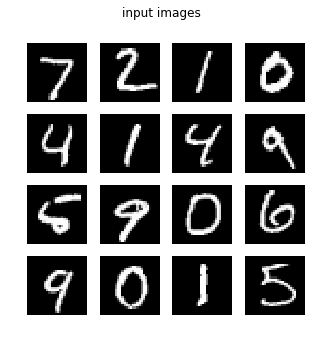

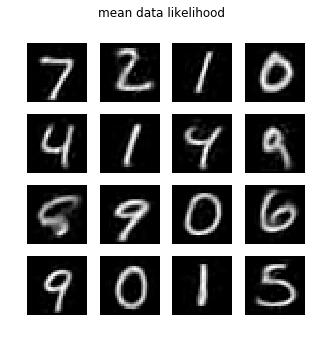

In [138]:
samples = sess.run(prior_samples, feed_dict={x_tr: np.expand_dims(x_truth,-1)})
samples.shape
inim, res = sess.run([x_tr,recon], feed_dict={x_tr: np.expand_dims(x_truth,-1), prior_sample: samples})
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(res[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
posterior_loss = []
ii     = 0
nepoch = 0
learning_rate = 1e-3

In [142]:
#train the nvp
while nepoch<1000:
  if (ii+1)*batch_size>len(x_train): 
    np.random.shuffle(x_train)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>100:
    learning_rate=1e-4
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train[batch_size*ii:batch_size*(ii+1)]
  _, ll = sess.run([opt_op,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  posterior_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1

starting epoch 820
7.26298
starting epoch 821
7.3390646
starting epoch 822
7.6767645
starting epoch 823
7.403802
starting epoch 824
7.3611774
starting epoch 825
7.216843
starting epoch 826
7.395504
starting epoch 827
7.451064
starting epoch 828
7.3928185
starting epoch 829
7.389846
starting epoch 830
7.293434
starting epoch 831
7.270045
starting epoch 832
7.4543786
starting epoch 833
7.496449
starting epoch 834
7.2095222
starting epoch 835
7.4845066
starting epoch 836
7.311516
starting epoch 837
7.1459236
starting epoch 838
7.594301
starting epoch 839
7.3255105
starting epoch 840
7.4092646
starting epoch 841
7.286358
starting epoch 842
7.217915
starting epoch 843
7.374605
starting epoch 844
7.5429273
starting epoch 845
7.5740943
starting epoch 846
7.336297
starting epoch 847
7.2174478
starting epoch 848
7.2173376
starting epoch 849
7.644237
starting epoch 850
7.4684052
starting epoch 851
7.250959
starting epoch 852
7.484912
starting epoch 853
7.33707
starting epoch 854
7.5505853
starti

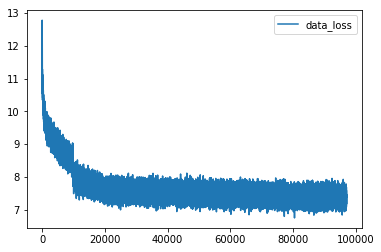

In [143]:
plt.figure()
plot(posterior_loss[::],label='data_loss')
legend()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 18:29:34.220510 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


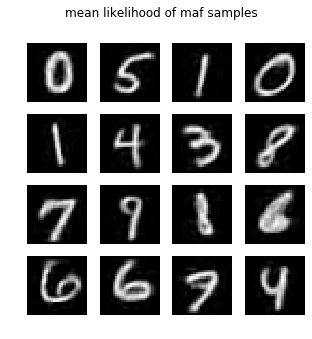

In [150]:
samples1 = sess.run(nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])

s = sess.run(sample_mean, feed_dict={prior_sample: samples1})

figure(figsize=(5,5))
suptitle('mean likelihood of maf samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:

#nvp_funcs.export(nvp_func_path,sess)


In [151]:
maf_s, prior_s = sess.run([nvp_funcs({'z_sample':approx_posterior.sample(),'sample_size':10000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'], prior.sample(10000)])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0505 18:29:45.170338 140256009533312 saver.py:1483] Saver not created because there are no variables in the graph to restore


(10000, 10)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


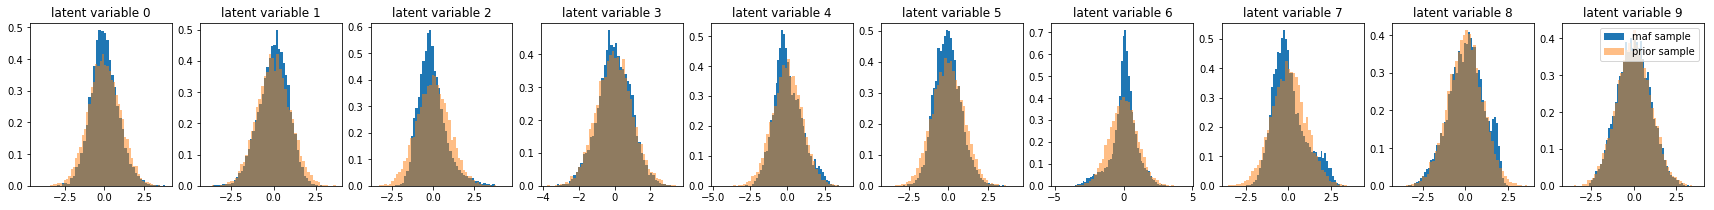

In [152]:
f=plt.figure()
f.set_figheight(3)
f.set_figwidth(30)
for ii in range(hidden_size):
  subplot(1,hidden_size,ii+1)
  plt.title('latent variable %d'%ii)
  _=plt.hist(maf_s[:,ii],bins=50, label='maf sample',normed=True)
  _=plt.hist(prior_s[:,ii],alpha=0.5,bins=50,label='prior sample',normed=True)
plt.legend()
plt.show()

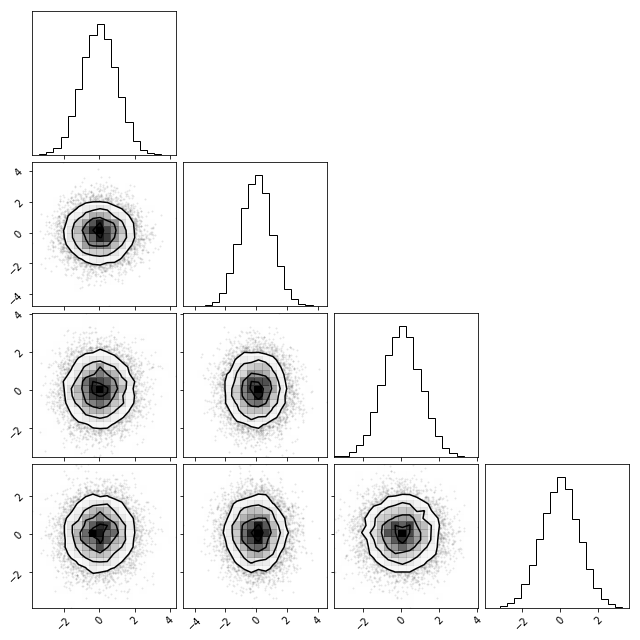

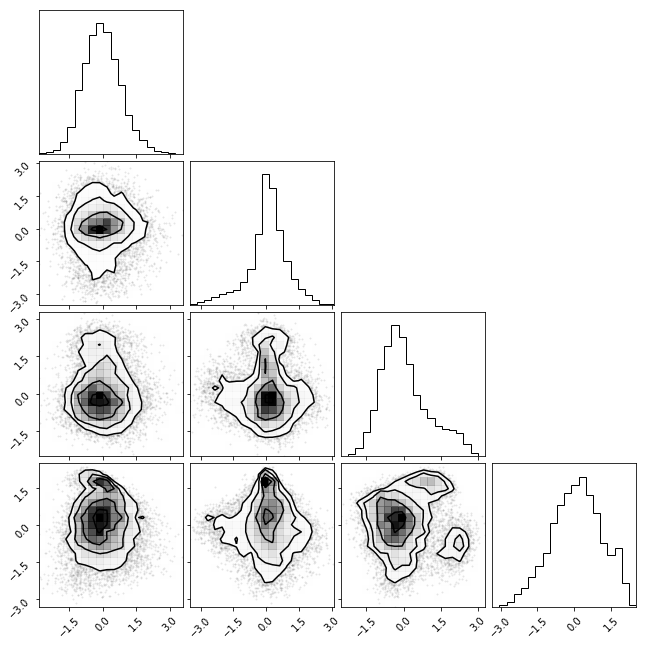

In [153]:
_ = corner.corner(prior_s[:,5:-1])
_ = corner.corner(maf_s[:,5:-1])

In [0]:
inc = 6
x_truth   = x_test[inc:batch_size_2+inc]
sigma_new = np.ones([28,28])*sigma_n
sigma_new[0:28,12:18]=1e8
mask=np.ones([28,28])
mask[np.where(sigma_new==1e8)]=0

data        = np.expand_dims(x_truth,-1)
sigma_new   = sigma_new.reshape([batch_size_2,784,n_channels])
mask        = mask.reshape([batch_size_2,784,n_channels])
data        = data*mask

0
4152.7983
2726.4856
2694.4846
2678.9692
2672.7112
2671.8958
2671.6257
2671.4753
2671.454
2671.4329
2671.4336
2671.4324
2671.4329
2671.433
2671.433
2671.432
2671.4324
2671.434
2671.4333
2671.4346
switching to lr 0.01
2671.433
2671.4329
2671.4326
2671.4336
2671.4363
2671.4333
2671.4346
2671.437
2671.433
2671.4336
switching to lr 0.001
2671.4336
2671.434
2671.4343
2671.4329
2671.4343
1
3811.0864
3265.3286
3246.2935
3223.16
3201.513
3185.8267
3177.116
3153.221
3127.8188
3121.9436
3097.812
3038.036
3013.153
3010.43
3009.3723
3008.8142
3008.3843
3007.4739
3006.754
3005.5774
switching to lr 0.01
3002.5042
2990.8652
2970.858
2960.531
2960.2358
2960.0886
2959.9856
2959.8418
2959.7576
2959.6394
switching to lr 0.001
2959.5413
2959.5164
2958.908
2958.5325
2958.4326
2
4883.8755
3936.309
3889.1729
3870.9258
3827.548
3222.4673
3209.918
3193.101
3182.969
3147.634
3081.492
3018.0442
2980.857
2958.5056
2940.5217
2932.172
2922.275
2922.1125
2922.2053
2922.118
switching to lr 0.01
2922.375
2922.1096
29

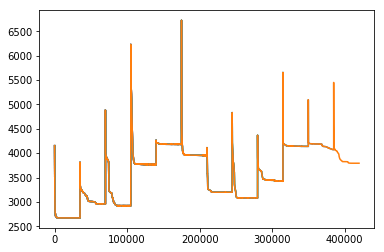

In [179]:
posterior_loss2=[]

l_minima=[]
map_minima=[]
for ii in range(12):
  print(ii)
  if ii ==1:
    ini = np.zeros((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  elif ii==0:
    #starting from truth
    ini = sess.run([mu_c],feed_dict={x_re: np.expand_dims(x_truth,-1), sigma_corr:sigma_new})[0]
  else:
    ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(20000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  print('switching to lr', lrate)
  for ii in range(10000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-3
  print('switching to lr', lrate)
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, sigma_corr:sigma_new})
    posterior_loss2.append(ll)
    if ii%1000==0:
      print(ll)
  plot(posterior_loss2,label='data_loss')
  l_minima+=[ll]
  map_minima+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new})]

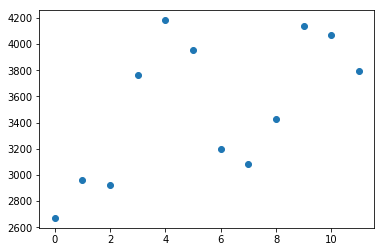

In [182]:
plt.figure()
plt.plot(np.arange(12),l_minima,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima,map_minima],open(minima_path+'nvp_minima.pkl','wb'))
l_minima,map_minima = pickle.load(open(minima_path+'nvp_minima.pkl','rb'))

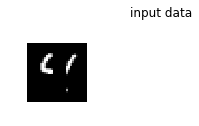

[ 0  2  1  7  6  8  3 11  5 10  9  4]


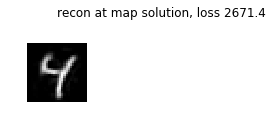

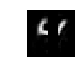

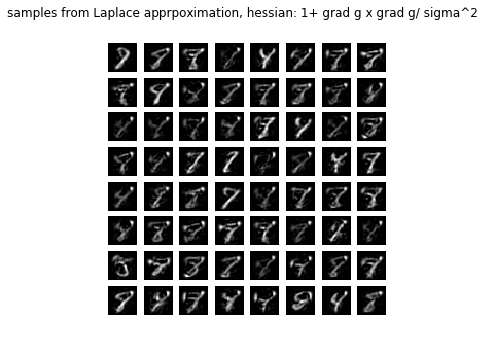

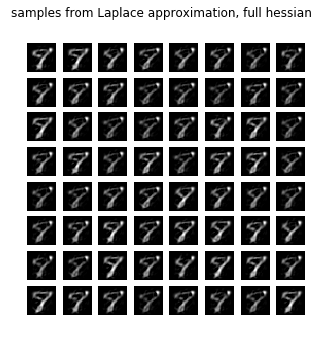

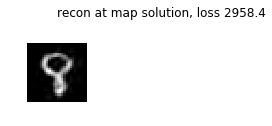

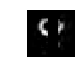

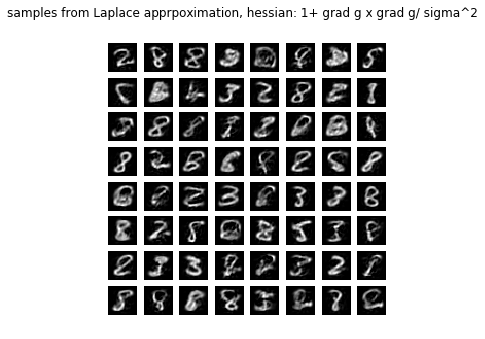

full hessian fails
eigen decomp fails


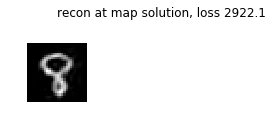

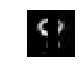

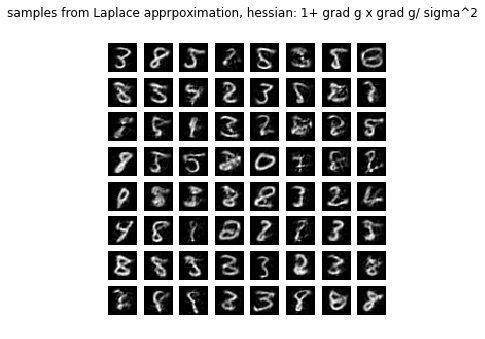

full hessian fails
eigen decomp fails


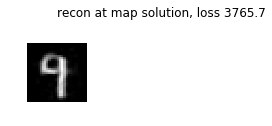

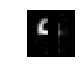

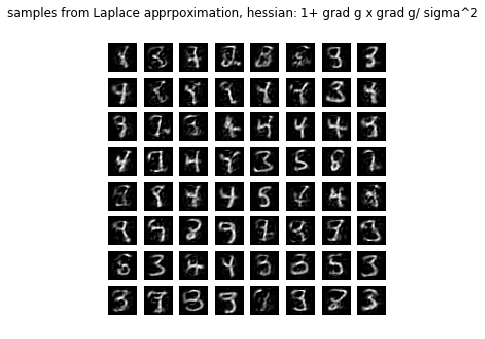

full hessian fails
eigen decomp fails


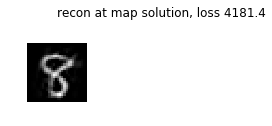

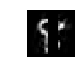

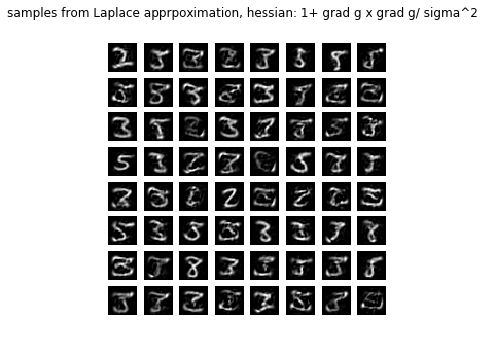

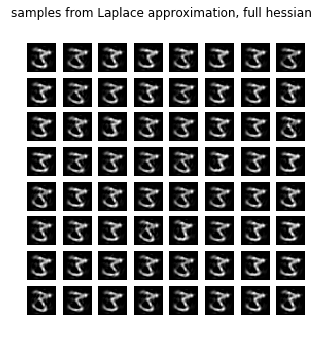

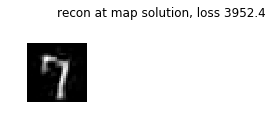

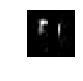

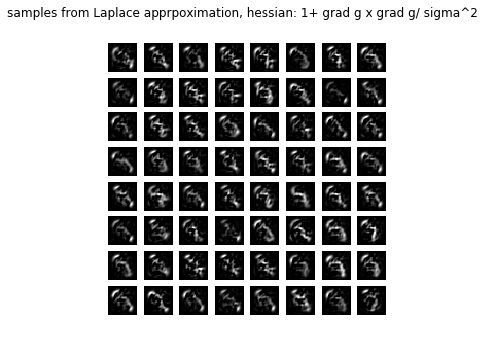

full hessian fails
eigen decomp fails


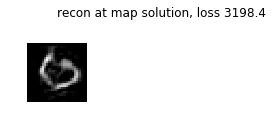

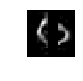

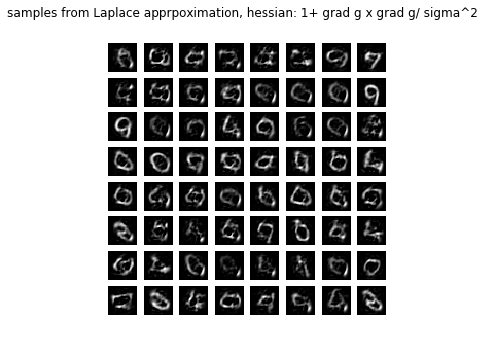

full hessian fails
eigen decomp fails


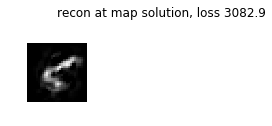

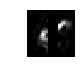

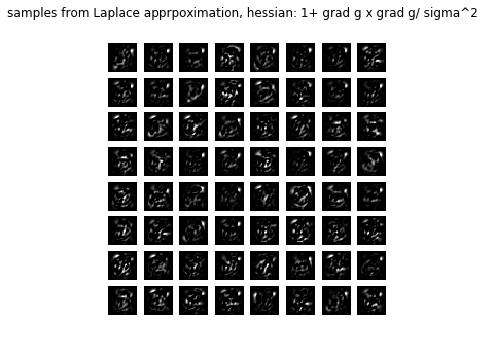

full hessian fails
eigen decomp fails


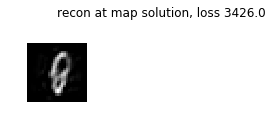

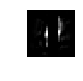

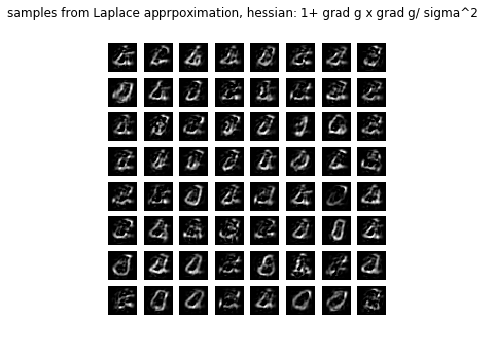

full hessian fails
eigen decomp fails


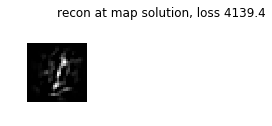

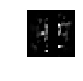

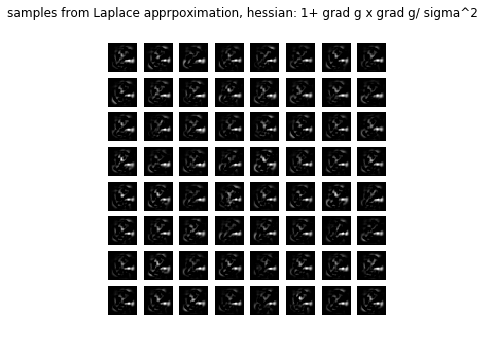

full hessian fails
eigen decomp fails


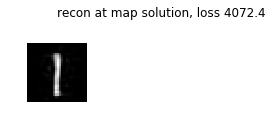

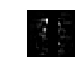

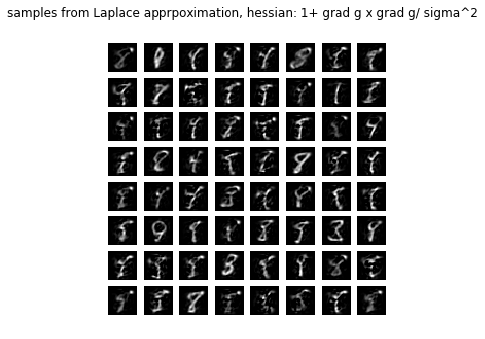

full hessian fails
eigen decomp fails


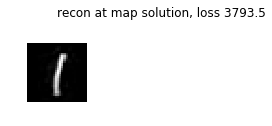

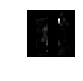

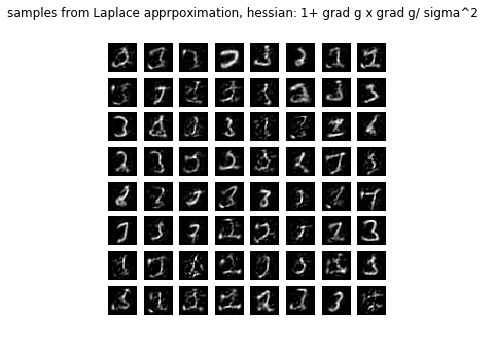

full hessian fails
eigen decomp fails


In [202]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
l_minima=np.asarray(l_minima)
map_minima=np.asarray(map_minima)
order = np.argsort(l_minima)
print(order)
for ii,ini_ in enumerate(map_minima[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})   
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new})
#   eig1_, eig2_ = sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
#   print(eig1_, 1./eig1_, eig2_)
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
#   figure(figsize=(5,5))
#   mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
#   for i in range(sample_size_z):
#     subplot(8,8,i+1)
#     imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
#     axis('off')    
#   plt.show()
    
  try:
    _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True})

    l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True})
    figure(figsize=(5,5))
    suptitle('samples from Laplace approximation, full hessian')
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
  except:
    try:
      print('full hessian fails')
      print(sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True}))
    except:
      print('eigen decomp fails')
#    figure(figsize=(5,5))
#     mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
#     for i in range(sample_size_z):
#       subplot(8,8,i+1)
#       imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
#       axis('off')  
#     plt.show()

    


W0505 20:09:46.391766 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)
(12, 1, 1, 10)


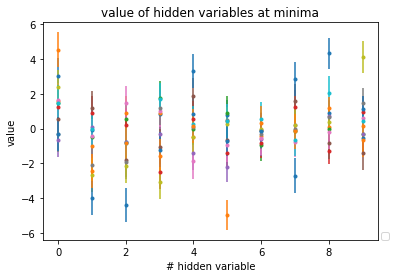

In [187]:
varis=np.asarray(varis)
map_minima=np.asarray(map_minima)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima)):
  print(map_minima.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

0
3909.2854
2912.962
2912.8591
2912.8481
2912.8425
2912.8333
2912.8623
2912.834
2912.831
2912.8303
1
7179.901
4163.7217
3812.8481
3804.3901
3804.0654
3804.0605
3804.0542
3804.064
3804.0757
3804.082
2
5634.2354
3954.1897
3847.7527
3826.404
3825.7104
3825.702
3825.71
3825.7231
3825.7012
3825.7148
3
5038.154
3984.1577
3979.6611
3979.5898
3979.6345
3979.5986
3979.6445
3979.7244
3979.6194
3979.5867
4
4830.8804
3939.3665
3932.6758
3932.5977
3932.591
3932.591
3932.5767
3932.594
3932.577
3932.6152
5
4499.8657
3035.0005
2859.436
2802.923
2798.6843
2798.6863
2798.6843
2798.6875
2798.6904
2798.687
6
4573.128
2978.2498
2932.5034
2932.248
2932.2412
2932.2327
2932.2405
2932.2324
2932.254
2932.236
7
5477.032
4033.145
4008.038
4008.0247
4008.028
4008.038
4008.0508
4008.0278
4008.0432
4008.0667
8
5304.25
3462.7974
3445.2554
3426.4714
3425.4297
3425.4285
3425.4292
3425.4316
3425.4402
3425.4316
9
4592.221
3963.7334
3952.3318
3952.2131
3952.2349
3952.2163
3952.2192
3952.236
3952.2158
3952.216


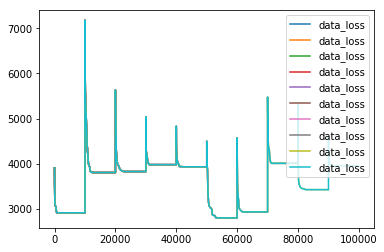

In [189]:
l_minima_old=[]
map_minima_old=[]
posterior_loss3=[]
for ii in range(10):
  print(ii)
  ini = np.random.randn((batch_size_2*hidden_size)).reshape((batch_size_2,hidden_size))
  sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini, nvp_prior: False, sigma_corr:sigma_new})
  lrate=1e-1
  for ii in range(3000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-2
  for ii in range(5000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  lrate=1e-4
  for ii in range(2000):
    _, ll = sess.run([opt_op2,loss_MAP],feed_dict={x_re: data, nvp_prior: False, sigma_corr:sigma_new})
    posterior_loss3.append(ll)
    if ii%1000==0:
      print(ll)
  l_minima_old+=[ll]
  map_minima_old+=[sess.run([MAP],feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior: False})]
  plot(posterior_loss3,label='data_loss')
  legend()

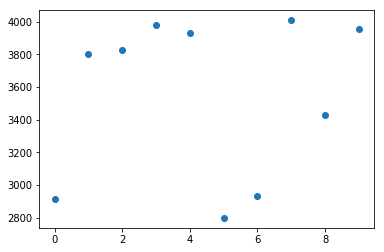

In [192]:
plt.figure()
plt.plot(np.arange(10),l_minima_old,ls='',marker='o')
plt.show()

In [0]:
import pickle
pickle.dump([l_minima_old,map_minima_old],open(minima_path+'minima.pkl','wb'))
l_minima_old,map_minima_old = pickle.load(open(minima_path+'minima.pkl','rb'))

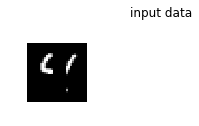

[5 0 6 8 1 2 4 9 3 7]


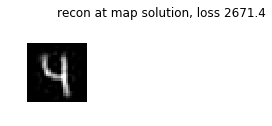

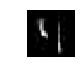

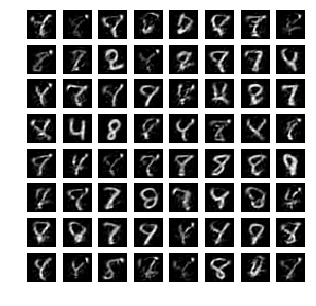

<Figure size 360x360 with 0 Axes>

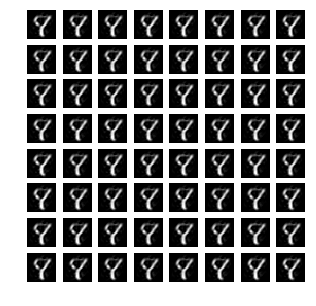

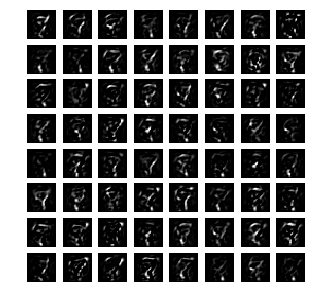

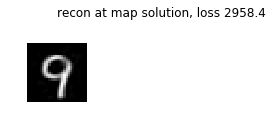

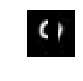

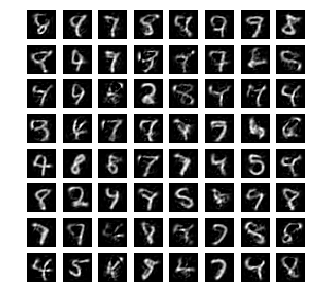

<Figure size 360x360 with 0 Axes>

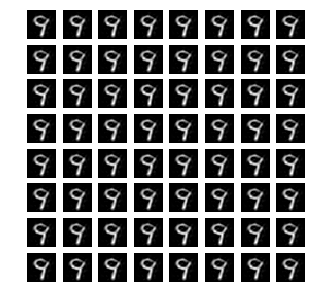

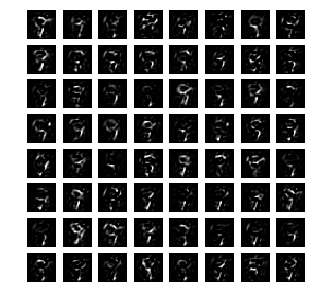

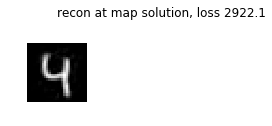

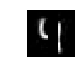

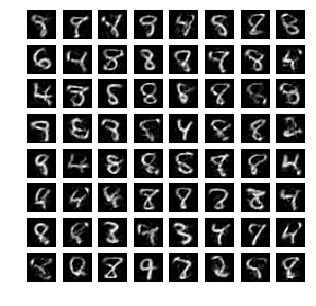

<Figure size 360x360 with 0 Axes>

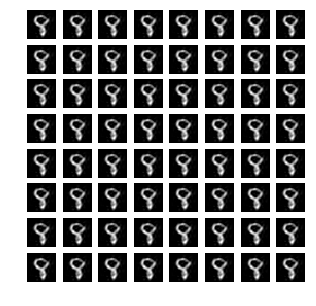

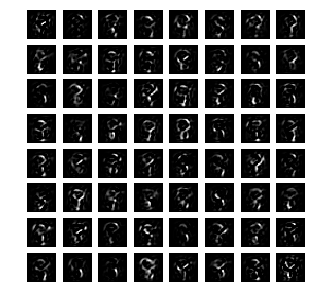

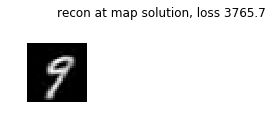

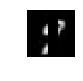

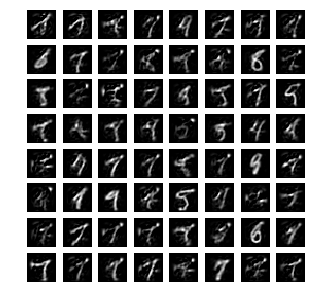

<Figure size 360x360 with 0 Axes>

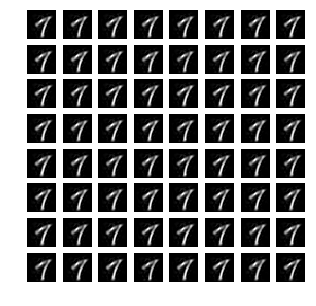

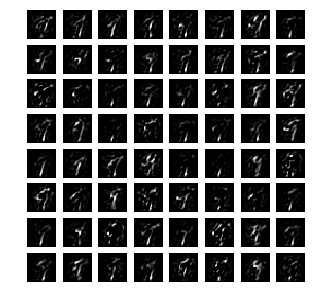

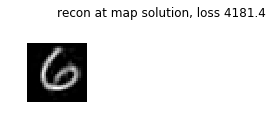

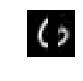

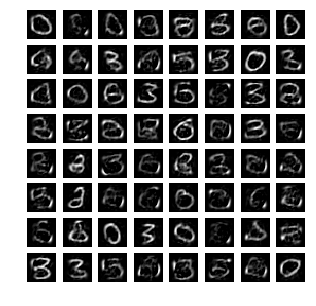

<Figure size 360x360 with 0 Axes>

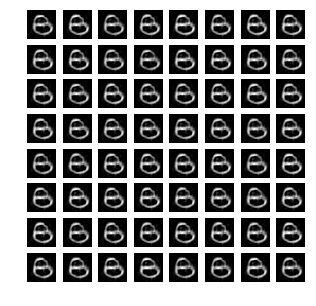

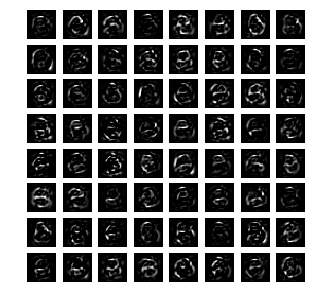

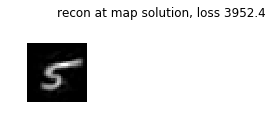

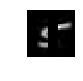

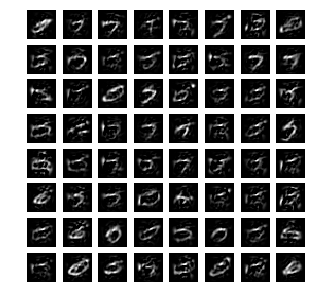

<Figure size 360x360 with 0 Axes>

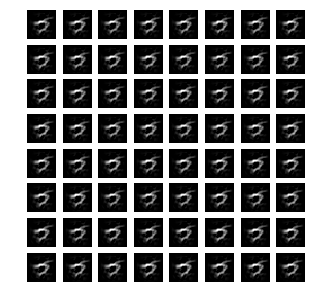

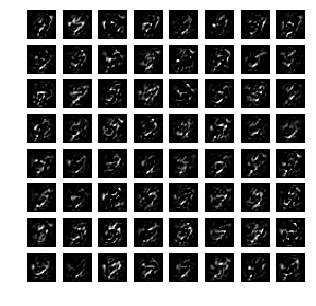

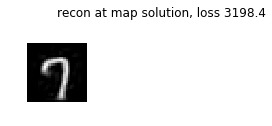

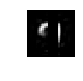

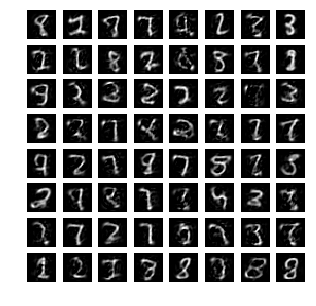

<Figure size 360x360 with 0 Axes>

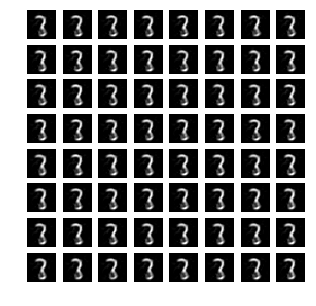

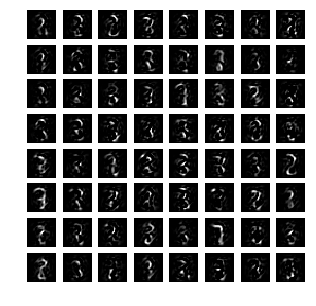

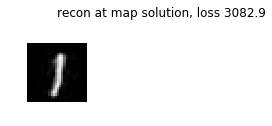

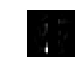

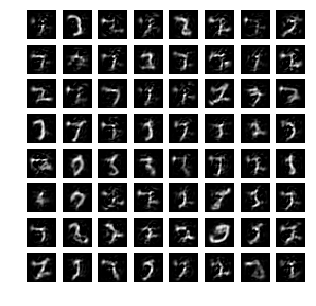

<Figure size 360x360 with 0 Axes>

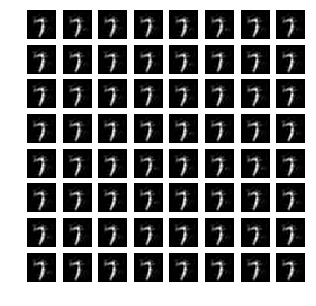

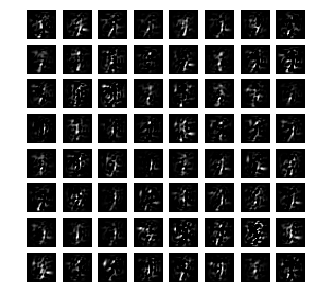

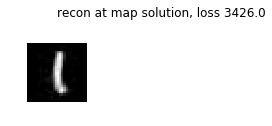

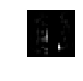

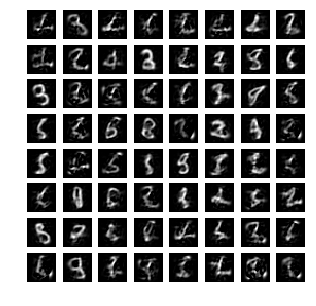

<Figure size 360x360 with 0 Axes>

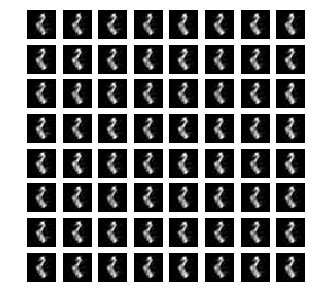

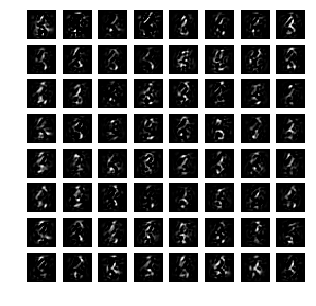

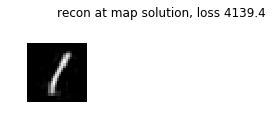

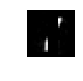

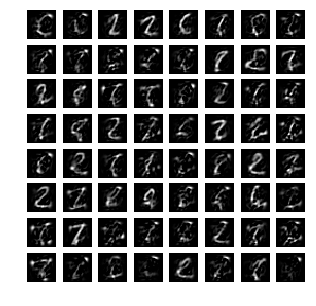

<Figure size 360x360 with 0 Axes>

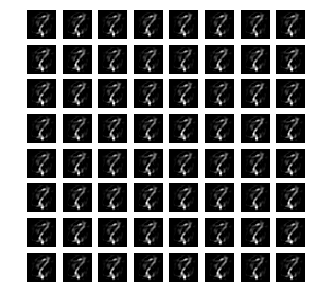

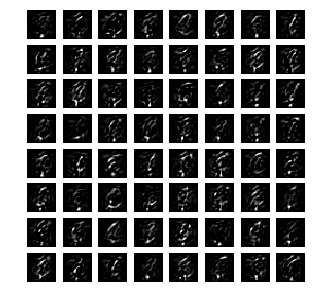

In [200]:
figure(figsize=(5,5))
suptitle('input data')
for i in range(min(batch_size_2,16)):
    subplot(4,4,i+1)
    imshow(np.reshape(data[i,:],(28,28)),cmap='gray',vmin=0)
    axis('off')
plt.show()

varis=[] 
l_minima_old=np.asarray(l_minima_old)
map_minima_old=np.asarray(map_minima_old)
order = np.argsort(l_minima_old)
print(order)
for ii,ini_ in enumerate(map_minima_old[order]):
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new})
  figure(figsize=(5,5))
  suptitle('recon at map solution, loss %.1f'%l_minima[ii])
  for i in range(min(batch_size_2,16)):
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
      plt.show()
      subplot(4,4,i+1)
      imshow(np.reshape(mean_at_map[i,:,0]*mask[0,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  _ = sess.run(MAP_reset,feed_dict={x_re: data, MAP_ini:ini_[0], sigma_corr:sigma_new, nvp_prior:False})
  mean_at_map = sess.run(MAP_mean,feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior:False})   
  _ = sess.run(update2,feed_dict={x_re: data, sigma_corr:sigma_new, nvp_prior:False})
#   eig1_, eig2_ = sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False})
#   print(eig1_, 1./eig1_, eig2_)
  _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  
  varis+=[sess.run(tf.linalg.diag_part(approx_posterior_laplace.covariance()),feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})]

  l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:False, nvp_prior:False})
  figure(figsize=(5,5))
  suptitle('samples from Laplace apprpoximation, hessian: 1+ grad g x grad g/ sigma^2')
  for i in range(sample_size_z):
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
      axis('off')
  plt.show()
  figure(figsize=(5,5))
  mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
#   for i in range(sample_size_z):
#     subplot(8,8,i+1)
#     imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
#     axis('off')    
#   plt.show()
    
  try:
    _ = sess.run(update3,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})

    l_samples = sess.run(lap_mean,feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False})
    suptitle('samples from Laplace apprpoximation, full hessian')
    figure(figsize=(5,5))
    for i in range(sample_size_z):
        subplot(8,8,i+1)
        imshow(np.reshape(l_samples[i,:,0],(28,28)),cmap='gray',vmin=0)
        axis('off')
    plt.show()
    figure(figsize=(5,5))
    mean_sample= np.reshape(np.mean(l_samples[:,:,0],axis=0),(28,28))
    for i in range(sample_size_z):
      suptitle('subtracting the mean')
      subplot(8,8,i+1)
      imshow(np.reshape(l_samples[i,:,0],(28,28))-mean_sample,cmap='gray',vmin=0)
      axis('off')  
    plt.show()
  except:
    try:
      print('full hessian fails')
      print(sess.run([eig1, eig2],feed_dict={x_re: data, sigma_corr:sigma_new, true_hess:True, nvp_prior:False}))
    except:
      print('eigen decomp fails')


    


W0505 20:45:53.899823 140256009533312 legend.py:1289] No handles with labels found to put in legend.


(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)
(10, 1, 1, 10)


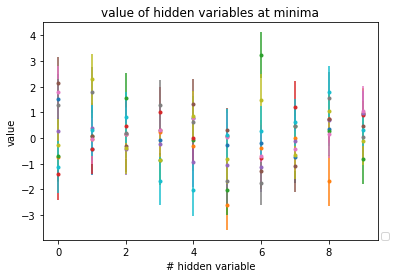

In [204]:
varis=np.asarray(varis)
map_minima_old=np.asarray(map_minima_old)
plt.figure()
plt.title('value of hidden variables at minima')
for ii in range(len(map_minima_old)):
  print(map_minima_old.shape)
  yerr_= np.sqrt(varis[ii,0])
  plt.errorbar(np.arange(hidden_size),np.squeeze(map_minima_old[ii]), yerr=yerr_, ls='', marker='.')
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()